# Debug Sjoin + overlay 

`overlay` is taking a long time, but since there's a dissolve, it's basically 1 row for T-Mobile compared to 1 row for the district boundary. Might be able to treat them as GeoSeries and see if it can go through faster.

`difference` can also take multiple rows for T-Mobile compared to 1 row for district boundary. In this case, the dissolve for where there's no coverage for T-Mobile should take place after the difference is taken.

* `difference`: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.difference.html


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
from shared_utils import geography_utils
from shared_utils import utils
import folium

from calitp.sql import to_snakecase
import A1_provider_prep
import A2_analysis
import A3_other

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# Original map - includes other stuff that isn't California
# tmobile = dg.read_parquet(
   # "gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_california.parquet"
# )

###  Notes
* Utilities.complete_difference_provider_district_level() stops at D6 for Verizon

###  Rerun AT&T because it doesn't look accurate

In [4]:
# att = dg.read_parquet("ATT.parquet")

In [5]:
# districts = A1_provider_prep.get_districts()

In [6]:
# att_complete = A1_provider_prep.complete_difference_provider_district_level(att, districts, "ATT")

### Debug D4
* Lots of D4 routes popping up as 100% intersecting with no coverage ares.

In [7]:
# Original AT&T map that is ONLY clipped to California
att = dg.read_parquet("ATT.parquet")

In [8]:
# att_gdf = att.compute()

In [9]:
# att_gdf.plot()

In [10]:
districts = A1_provider_prep.get_districts()

In [11]:
# Subset to D4
d4 =  districts[districts.district == 4]

<AxesSubplot:>

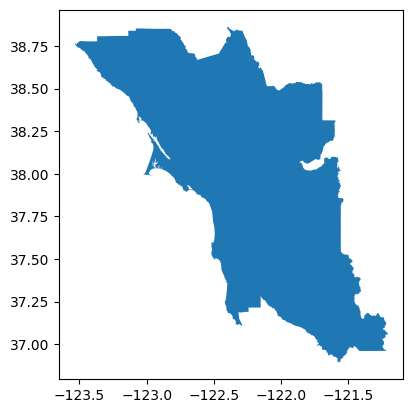

In [12]:
# Og d4 shape
d4.plot()

In [14]:
# Clip original AT&T map against D4
# clipped = dg.clip(verizon, d4)

In [15]:
# clipped_gdf = clipped.compute()

In [16]:
# clipped_gdf.plot()

In [17]:
# Finding no coverage areas 
# d4_no_coverage = A1_provider_prep.find_difference_and_clip(verizon, d4)

In [18]:
# d4_no_coverage.plot()

* Sjoin should reflect the at&t provider map (which shows the areas of no coverage or yes coverage)

In [19]:
# Finding no coverage areas using iloc_find_difference_district
# att_d4_iloc = A1_provider_prep.iloc_find_difference_district(att, d4, 'att')

saved att_d4 parquet
att_no_coverage_d4 parquet


In [20]:
# so the sjoin should reflect the at&t provider map (which shows the areas of no coverage or yes coverage)
att_d4_iloc.shape

(1, 1)

In [21]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
sjoin_d4_att_intersects = dg.sjoin(
        att, 
        d4, 
        how="inner", 
        predicate = "intersects"
    ).drop(columns = "index_right")

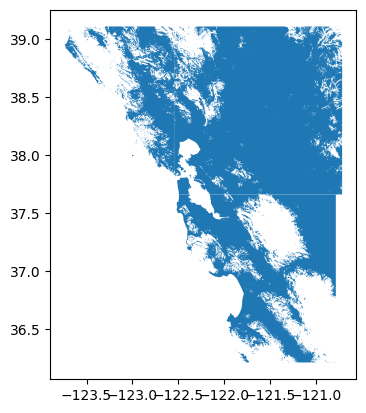

In [22]:
sjoin_d4_att_intersects_gdf = sjoin_d4_att_intersects.compute().plot()

In [23]:
att_d4_iloc.columns

Index(['geometry'], dtype='object')

In [24]:
sjoin_d4_att_intersects_difference = sjoin_d4_att_intersects.difference(
        d4.geometry.iloc[0], 
    ).reset_index()

In [45]:
sjoin_d4_att_intersects_difference = sjoin_d4_att_intersects_difference.compute()

<AxesSubplot:>

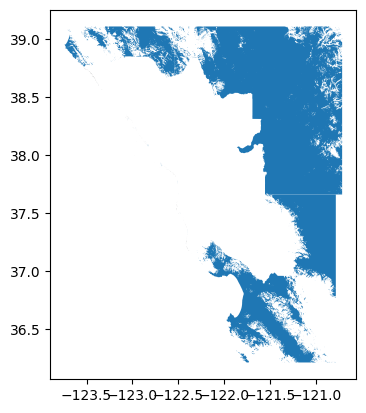

In [46]:
sjoin_d4_att_intersects_difference.plot()

In [25]:
# sjoin_d4_att_intersects_difference_gdf = sjoin_d4_att_intersects_difference.compute()

In [47]:
unique_routes = A3_other.load_unique_routes_df()

In [28]:
d4_routes = A2_analysis.comparison(unique_routes, att_d4_iloc)

In [29]:
d4_routes2 = A2_analysis.dissolve_summarize(d4_routes)

In [30]:
# d4_routes2[['agency','long_route_name','percentage_route_covered']].sort_values('agency')

In [31]:
# https://stackoverflow.com/questions/73767559/geopandas-explore-how-to-plot-more-than-one-layer
m = att_d4_iloc.explore(color="blue", name="D4",  width=700,
    height=500,)

In [32]:

m = d4_routes2.explore(m=m,)

In [48]:
# m 

### Alameda County

In [34]:
counties = A1_provider_prep.get_counties()

In [35]:
alameda_only = counties[counties.county_name == 'Alameda']

<AxesSubplot:>

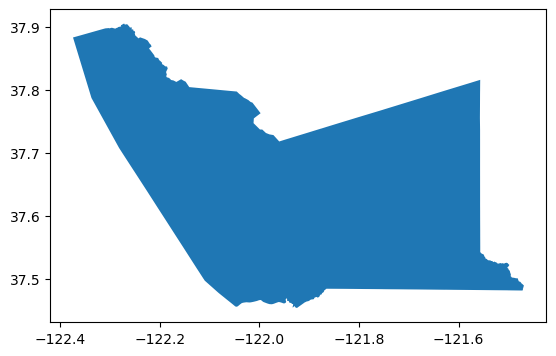

In [36]:
alameda_only.plot()

In [37]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
sjoin_alameda_att = dg.sjoin(
        att, 
        alameda_only, 
        how="inner", 
        predicate = "intersects"
    ).drop(columns = "index_right")

<AxesSubplot:>

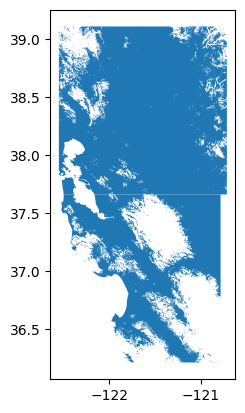

In [38]:
sjoin_alameda_att.compute().plot()

In [39]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
clip_alameda_att = dg.clip(
        att, 
        alameda_only)

<AxesSubplot:>

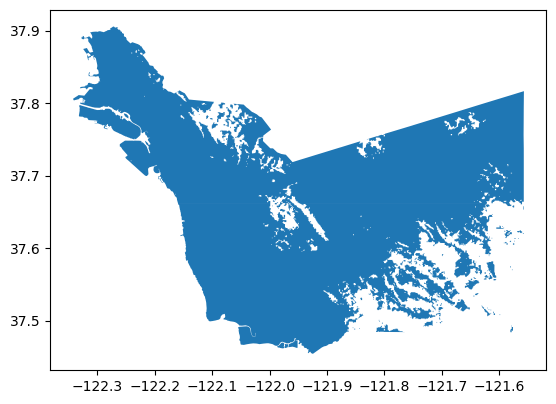

In [40]:
clip_alameda_att.compute().plot()

In [41]:
# Load in the version I created using function "complete_difference_provider_district_level"
att_function = dg.read_parquet(f"{A1_provider_prep.GCS_FILE_PATH}att_all_counties.parquet")

In [42]:
att_function = A1_provider_prep.simplify_geometry(att_function)

AttributeError: module 'A1_provider_prep' has no attribute 'simplify_geometry'

In [ ]:
# sjoin original AT&T map against D4
# Just breaking apart iloc find difference district
clip_alameda_att2 = dg.clip(
        att_function, 
        alameda_only)

In [ ]:
clip_alameda_att2 = clip_alameda_att2.compute() 

In [ ]:
# Overlay
overlay_df2 = A2_analysis.comparison(unique_routes,clip_alameda_att2)

In [ ]:
# Create a new route length for portions covered by cell coverage
overlay_df3 = A2_analysis.dissolve_summarize(overlay_df2)

In [ ]:
overlay_df3.drop(columns=['geometry']).sort_values('percentage_route_covered')

In [ ]:
kern = A1_provider_prep.correct_kern()

In [ ]:
kern = att.difference(
        kern.geometry.iloc[0], 
    ).reset_index()

In [ ]:
kern2 = A1_provider_prep.simplify_geometry(kern)

In [ ]:
# Overlay
kern_routes = A2_analysis.comparison(unique_routes,kern2)
kern_routes = A2_analysis.dissolve_summarize(kern_routes)

In [ ]:
kern_routes.drop(columns=['geometry']).sort_values('percentage_route_covered')

### iloc function county

In [ ]:
def find_difference_county(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
) -> dg.GeoDataFrame:
    
    # Clip provider to CT district
    provider_county = dg.sjoin(
        provider_df, 
        county_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Compute back to normal gdf
    provider_county = provider_county.compute()
    
    # Get areas without coverage
    no_coverage = provider_county.difference(
        county_df.geometry.iloc[0], 
    ).reset_index()
    
    # Turn to gdf
    no_coverage = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )
    # Set geometry
    no_coverage = no_coverage.set_geometry('geometry')
    
    return no_coverage

In [ ]:
counties.plot()

In [ ]:
kern.plot()

In [ ]:
counties.geometry.is_valid.all()

In [ ]:
verizon = utilities.load_verizon()

In [ ]:
kern_v = find_difference_county(verizon, kern)

In [ ]:
county_list = counties.county_name.sort_values().unique().tolist()

In [ ]:
def complete_difference_provider_county_level(
    provider_df: dg.GeoDataFrame, 
    county_df: gpd.GeoDataFrame,
    provider_name: str,) -> dg.GeoDataFrame:
    full_gdf = pd.DataFrame()
    
    county_list = county_df.county_name.sort_values().unique().tolist()
    
    for i in county_list:
        result = find_difference_county(
            provider_df, 
            county_df[county_df.county_name==i]
        )

        full_gdf = dd.multi.concat([full_gdf, result], axis=0)
        print(f"done for {i}")
    full_gdf = full_gdf.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_gdf

In [ ]:
# test = complete_difference_provider_county_level(verizon, counties, 'verizon',)

In [ ]:
test_ver.plot()

#### iloc testing

In [ ]:
# For files that are split apart by counties/districts
# That needs to be combined together to create a full California map
# https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/
def concat_all_areas(file_list:list, provider_name:str):
    main_dataframe = pd.DataFrame(gpd.read_parquet(file_list[0]))
    for i in range(1,len(file_list)):
        data = pd.gpd.read_parquet(file_list[i])
        df = pd.DataFrame(data)
        full_dataframe = dd.multi.concat([full_dataframe,df],axis=1)
        
    full_dataframe = full_dataframe.compute()
    
    utils.geoparquet_gcs_export(full_gdf, utilities.GCS_FILE_PATH, f"{provider_name}_no_coverage_complete_CA")
    return full_dataframe

In [ ]:
test_tmobile.plot()

In [ ]:
# Blue parts are areas with coverage in D5. 
"""
tmobile_district = dg.sjoin(
    tmobile[["geometry"]], 
    ct_all_districts[ct_all_districts.district==5],
    how="inner", 
    predicate="intersects"
).drop(columns = "index_right")"""

In [ ]:
tmobile_d5 = tmobile_district.compute()

In [ ]:
len(tmobile_d5)

In [ ]:
tmobile_d5.head(1)

In [ ]:
type(tmobile_d5)

In [ ]:
# Getting areas without coverage in D2. 
#no_coverage = tmobile_d5.difference(
  #      ct_all_districts[ct_all_districts.district==5].geometry.iloc[0], 
   # ).reset_index()

In [ ]:
# This line grabs the actual polygon 
# ct_all_districts[ct_all_districts.district==2].geometry.iloc[0]

In [ ]:
no_coverage_d5 = (no_coverage.reset_index()
                  .dissolve()
                  .rename(columns = {0: 'geometry'})
                  [["geometry"]]
                 )

In [ ]:
no_coverage_d5 = no_coverage_d5.set_geometry('geometry')

In [ ]:
type(no_coverage_d5), no_coverage_d5.columns

In [ ]:
utils.geoparquet_gcs_export(no_coverage_d5, utilities.GCS_FILE_PATH, f"test_d5")

In [ ]:
test_d5 = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/test_d5.parquet"
)

In [ ]:
type(test_d5)

In [ ]:
test_d5.plot()

#### Break apart dissolve

In [ ]:
ct_d5  = (ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5

In [ ]:
ct_all_districts[ct_all_districts.district==5]

In [ ]:
ct_d5.plot()

In [ ]:
tmobile_district = dg.sjoin(
        tmobile[['geometry']], 
        ct_d5, 
        how="inner", 
        predicate="intersects"
    )

In [ ]:
tmobile_district_gdf = tmobile_district.compute()

In [ ]:
len(tmobile_district_gdf)

In [ ]:
tmobile_district_gdf.head(1)

In [ ]:
"""
tmobile_5 = (tmobile_district.drop(columns = "index_right").dissolve(by="district")
                    .reset_index()
                    .compute()
                   )"""

In [ ]:
len(tmobile_5)

In [ ]:
district_file = tmobile_5.district.iloc[0]

In [ ]:
district_file

In [ ]:
tmobile_5

In [ ]:
# utils.geoparquet_gcs_export(tmobile_5, utilities.GCS_FILE_PATH,f"tmobile_d{district_file}.parquet")

In [ ]:
tmobile_align_true = (tmobile_5.difference(
            (ct_all_districts[ct_all_districts.district==5]).reset_index(), 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   

In [ ]:
type(tmobile_align_true)

In [ ]:
tmobile_align_true = tmobile_align_true.set_geometry('geometry')

In [ ]:
# I get an error when plotting /opt/conda/lib/python3.9/site-packages/geopandas/array.py:938: RuntimeWarning: All-NaN slice encountered
tmobile_align_true.plot()

In [ ]:
def sjoin_to_district_find_difference(
    tmobile: dg.GeoDataFrame, 
    district_df: gpd.GeoDataFrame
) -> dg.GeoDataFrame:
    tmobile_district = dg.sjoin(
        tmobile, 
        district_df, 
        how="inner", 
        predicate="intersects"
    ).drop(columns = "index_right")
    
    # Dissolve so that it's just 1 row for TMobile coverage in that district
    tmobile_diss = (tmobile_district.dissolve(by="district")
                    .reset_index()
                    .compute()
                   )
    
    # Maybe stash intermediate output here?
    d = district_df.district.iloc[0]
    tmobile_diss.to_parquet(f"tmobile_d{d}.parquet")
    
    # Instead of gpd.overlay(), since tmobile_diss is 1 row and 
    # district_df is 1 row,
    # can treat them as GeoSeries, align=True, to do row-wise comparison
    no_coverage = (tmobile_diss.difference(
            ct_all_districts[ct_all_districts.district==i], 
            align=True
        ).reset_index()
        .rename(columns = {0: 'geometry'})
    )   
    
    no_coverage.to_parquet(f"no_coverage_d{d}.parquet")
    
    return no_coverage

In [ ]:
results = []

for i in [1]:
    dissolved_result = sjoin_to_district_find_difference(
        tmobile[["geometry"]], 
        ct_all_districts[ct_all_districts.district==i]
    )
    
    results.append(dissolved_result)

In [ ]:
ddf = dd.multi.concat(results, axis=0)

In [ ]:
df = ddf.compute()